In [1]:
import numpy as np
import pandas as pd
import torch
import sys
sys.path.insert(1, "../")
import ml_utils.save_io as io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#import matplotlib
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 40}
#matplotlib.rc('font', **font)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
root_paths = [
    "/data2/pdp/grantsrb/sa_saves/",
]
exp_folders = []
for root_path in root_paths:
    for i,exp_folder in enumerate(os.listdir(root_path)):
        exp_folders.append(os.path.join(root_path, exp_folder))
        print(i,exp_folders[-1])

0 /data2/pdp/grantsrb/sa_saves/gpt2proj_blog
1 /data2/pdp/grantsrb/sa_saves/bloom560_proj
2 /data2/pdp/grantsrb/sa_saves/scaling
3 /data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search
4 /data2/pdp/grantsrb/sa_saves/test
5 /data2/pdp/grantsrb/sa_saves/bloom560nnproj
6 /data2/pdp/grantsrb/sa_saves/trsearch_bloom560m


In [3]:
idxs = [ 3 ]

In [4]:
temp_folders = []
for idx in idxs:
    exp_folder = exp_folders[idx]
    new_folders = io.get_model_folders(exp_folder, incl_full_path=True)
    temp_folders = temp_folders + new_folders
for i,folder in enumerate(temp_folders):
    print(i,folder)

0 /data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_hid_mult4
1 /data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_1_cmp_layer-2_kl_scale0.001_proj_cmprTrue_proj_hid_mult4
2 /data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_2_cmp_layer-2_kl_scale0.1_proj_cmprTrue_proj_hid_mult4
3 /data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_3_cmp_layer-1_kl_scale0.01_proj_cmprTrue_proj_hid_mult4
4 /data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_4_cmp_layer-2_kl_scale0.01_proj_cmprTrue_proj_hid_mult4
5 /data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_5_cmp_layer-1_kl_scale0.1_proj_cmprTrue_proj_hid_mult4


In [5]:
idxs = [i for i in range(len(temp_folders))]
#idxs = [0,1,2,3,4]

In [6]:
model_folders = [temp_folders[i] for i in idxs]
model_folders

['/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_hid_mult4',
 '/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_1_cmp_layer-2_kl_scale0.001_proj_cmprTrue_proj_hid_mult4',
 '/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_2_cmp_layer-2_kl_scale0.1_proj_cmprTrue_proj_hid_mult4',
 '/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_3_cmp_layer-1_kl_scale0.01_proj_cmprTrue_proj_hid_mult4',
 '/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_4_cmp_layer-2_kl_scale0.01_proj_cmprTrue_proj_hid_mult4',
 '/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search/gpt2proj_kl_search_5_cmp_layer-1_kl_scale0.1_proj_cmprTrue_proj_hid_mult4']

## Load Data

In [7]:
def load_loss_data(model_folder):
    df = None
    checkpts = io.get_checkpoints(model_folder)
    if len(checkpts)==0: return None
    for checkpt in checkpts:
        try:
            data = io.load_checkpoint(checkpt)
        except:
            print("error")
            print(model_folder, checkpt)
        if "state_dict" in data: del data["state_dict"]
        if "optim_dict" in data: del data["optim_dict"]
        hyps = data["hyps"]
        del data["hyps"]
        if df is None:
            df = { k: [v] for k,v in data.items() }
        else:
            for k,v in data.items():
                df[k].append(v)
    df = pd.DataFrame(df)
    for k,v in hyps.items():
        if type(v)==list: continue
        try:
            df[k] = v
        except:
            print("Failure to place", k, "in dataframe")
    return df

In [8]:
dfs = []
for model_folder in tqdm(model_folders):
    df = load_loss_data(model_folder)
    if df is not None:
        dfs.append(df)
df = pd.concat(dfs, sort=True)
df = df.reset_index()
df["name"] = df.apply(lambda x: x.save_folder.split("/")[-1], axis=1)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


,index,_model_string,abbrev_len,batch_size,checkpt_mod,cmp_layer,cmp_len,csl_scale,csl_task,data_batch_size,data_cache,data_root,dataset,device_map,epoch,examples,exp_folder,exp_name,exp_num,gen_ids,gen_targs,git_hash,grad_clip,grad_scaling,kl_scale,kl_train_loss,l2,loaded_path,lr,max_val_loops,mid_epoch,model_folder,model_parallel,model_string,multi_gpu,n_cmps,n_data_procs,n_epochs,n_grad_loops,n_train_loops,pad_token,patience,proj_cmpr,proj_hid_mult,rank,rmb_only,rmb_task,save_folder,save_root,search_keys,seed,sep_cmpr,seq_len,seq_overlap,test_model_str,torch_dtype,train_acc,train_embs,train_lmhead,train_loss,val_acc,val_batch_size,val_loss,name
0,0,bigscience/bloomz-560m,None,16,None,-1,30,1,False,64,/data2/pdp/grantsrb/.cache,/data2/pdp/grantsrb/datasplits/,blog_authorship_corpus,None,0,[{'ctx': ' Bull Cow ...,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search,gpt2proj_kl_search,0,False,False,76b67b0ad9c33b6f8a206ac4579e605c4c5b9f53,0,False,0.001,0.06746,0,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,0.0005,500,False,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...,False,gpt2,False,1,1,30,4,10000,<|endoftext|>,5,True,4,0,False,False,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,/data2/pdp/grantsrb/sa_saves/,_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_...,123456,False,40,0,None,float32,0.17135,False,False,1.45141,0.01039,50,3.05043,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...
1,1,bigscience/bloomz-560m,None,16,None,-1,30,1,False,64,/data2/pdp/grantsrb/.cache,/data2/pdp/grantsrb/datasplits/,blog_authorship_corpus,None,1,"[{'ctx': ' has violated his ""No Drinking"" poli...",/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search,gpt2proj_kl_search,0,False,False,76b67b0ad9c33b6f8a206ac4579e605c4c5b9f53,0,False,0.001,0.04190,0,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,0.0005,500,False,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...,False,gpt2,False,1,1,30,4,10000,<|endoftext|>,5,True,4,0,False,False,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,/data2/pdp/grantsrb/sa_saves/,_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_...,123456,False,40,0,None,float32,0.22051,False,False,1.26004,0.01110,50,2.96926,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...
2,2,bigscience/bloomz-560m,None,16,None,-1,30,1,False,64,/data2/pdp/grantsrb/.cache,/data2/pdp/grantsrb/datasplits/,blog_authorship_corpus,None,2,[{'ctx': '. Oh and Chris using my cell phone b...,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search,gpt2proj_kl_search,0,False,False,76b67b0ad9c33b6f8a206ac4579e605c4c5b9f53,0,False,0.001,0.03822,0,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,0.0005,500,False,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...,False,gpt2,False,1,1,30,4,10000,<|endoftext|>,5,True,4,0,False,False,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,/data2/pdp/grantsrb/sa_saves/,_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_...,123456,False,40,0,None,float32,0.22785,False,False,1.22827,0.00864,50,2.95914,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...
3,3,bigscience/bloomz-560m,None,16,None,-1,30,1,False,64,/data2/pdp/grantsrb/.cache,/data2/pdp/grantsrb/datasplits/,blog_authorship_corpus,None,3,[{'ctx': '. This is an easy merit badge to te...,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_search,gpt2proj_kl_search,0,False,False,76b67b0ad9c33b6f8a206ac4579e605c4c5b9f53,0,False,0.001,0.03685,0,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,0.0005,500,False,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...,False,gpt2,False,1,1,30,4,10000,<|endoftext|>,5,True,4,0,False,False,/data2/pdp/grantsrb/sa_saves/gpt2proj_kl_searc...,/data2/pdp/grantsrb/sa_saves/,_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_...,123456,False,40,0,None,float32,0.23081,False,False,1.21592,0.00894,50,2.93774,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...
4,4,bigscience/bloomz-560m,None,16,None,-1,30,1,False,64,/data2/pdp/grantsrb/.cache,/data2/pdp/grantsrb/datasplits/,blog_authorship_corpus,None,4,[{'ctx': '... don't need that) algebra 3 w/sta...,/data2/pdp/grantsrb/sa_save

In [9]:
base = pd.read_csv("../baseline_results.csv")
print("Baseline Performances")
base = base[["model_string", "cmp_len", "seq_len", "tlow_loss","tlow_acc","low_loss","low_acc","thigh_loss","thigh_acc","high_loss","high_acc"]]
base.T

Baseline Performances


,0,1
model_string,bigscience/bloomz-560m,gpt2
cmp_len,10,30
seq_len,20,40
tlow_loss,1.217,1.1745
tlow_acc,0.2408,0.2371
low_loss,2.9531,2.941
low_acc,0.0079,0.0099
thigh_loss,1.1089,1.1184
thigh_acc,0.2884,0.2569
high_loss,2.716,2.626


In [10]:
print("Model Performances")

idx = df.groupby("save_folder")["epoch"].transform(max)==df["epoch"]
cols = [
    "exp_name", "exp_num", "name",
    "train_loss", "train_acc", "val_loss", "val_acc",
]
if "rmb_train_loss" in df.columns:
    cols = cols + ["rmb_train_loss", "rmb_train_acc", "rmb_val_loss", "rmb_val_acc",]
if "csl_train_loss" in df.columns:
    cols = cols + ["csl_train_loss", "csl_train_acc", "csl_val_loss", "csl_val_acc",]
df[idx][cols].T

Model Performances


,8,17,26,35,44,53
exp_name,gpt2proj_kl_search,gpt2proj_kl_search,gpt2proj_kl_search,gpt2proj_kl_search,gpt2proj_kl_search,gpt2proj_kl_search
exp_num,0,1,2,3,4,5
name,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...,gpt2proj_kl_search_1_cmp_layer-2_kl_scale0.001...,gpt2proj_kl_search_2_cmp_layer-2_kl_scale0.1_p...,gpt2proj_kl_search_3_cmp_layer-1_kl_scale0.01_...,gpt2proj_kl_search_4_cmp_layer-2_kl_scale0.01_...,gpt2proj_kl_search_5_cmp_layer-1_kl_scale0.1_p...
train_loss,1.19487,1.20029,4.69294,1.51062,1.52085,4.60735
train_acc,0.23824,0.2403,0.23392,0.23665,0.23628,0.23451
val_loss,2.92031,2.87428,30.35572,5.40071,5.39673,30.54736
val_acc,0.00984,0.0144,0.00967,0.01105,0.01037,0.01081


## Performance Statistics

In [11]:
thigh_loss = float(base.iloc[0]["thigh_loss"])
tlow_loss = float(base.iloc[0]["tlow_loss"])
diff = tlow_loss - thigh_loss
df["trecover_loss"] = df.apply(lambda x: (tlow_loss - x.train_loss)/diff, axis=1)

high_loss = float(base.iloc[0]["high_loss"])
low_loss = float(base.iloc[0]["low_loss"])
diff = low_loss - high_loss
df["recover_loss"] = df.apply(lambda x: (low_loss-x.val_loss)/diff, axis=1)

thigh_acc = float(base.iloc[0]["thigh_acc"])
tlow_acc = float(base.iloc[0]["tlow_acc"])
diff = thigh_acc - tlow_acc
df["trecover_acc"] = df.apply(lambda x: (x.train_acc-tlow_acc)/diff, axis=1)

high_acc = float(base.iloc[0]["high_acc"])
low_acc = float(base.iloc[0]["low_acc"])
diff = high_acc - low_acc
df["recover_acc"] = df.apply(lambda x: (x.val_acc-low_acc)/diff, axis=1)



In [12]:
idx = df.groupby("save_folder")["epoch"].transform(max)==df["epoch"]
cols = [
    "exp_name", "exp_num", "name",
    "train_loss", "trecover_loss", "train_acc", "trecover_acc", "val_loss", "recover_loss", "val_acc", "recover_acc",
]
df[idx][cols]

,exp_name,exp_num,name,train_loss,trecover_loss,train_acc,trecover_acc,val_loss,recover_loss,val_acc,recover_acc
8,gpt2proj_kl_search,0,gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001...,1.19487,0.204718,0.23824,-0.053782,2.92031,0.138296,0.00984,0.233735
17,gpt2proj_kl_search,1,gpt2proj_kl_search_1_cmp_layer-2_kl_scale0.001...,1.20029,0.154579,0.24030,-0.010504,2.87428,0.332434,0.01440,0.783133
26,gpt2proj_kl_search,2,gpt2proj_kl_search_2_cmp_layer-2_kl_scale0.1_p...,4.69294,-32.154857,0.23392,-0.144538,30.35572,-115.574104,0.00967,0.213253
35,gpt2proj_kl_search,3,gpt2proj_kl_search_3_cmp_layer-1_kl_scale0.01_...,1.51062,-2.716189,0.23665,-0.087185,5.40071,-10.323113,0.01105,0.379518
44,gpt2proj_kl_search,4,gpt2proj_kl_search_4_cmp_layer-2_kl_scale0.01_...,1.52085,-2.810823,0.23628,-0.094958,5.39673,-10.306326,0.01037,0.297590
53,gpt2proj_kl_search,5,gpt2proj_kl_search_5_cmp_layer-1_kl_scale0.1_p...,4.60735,-31.363090,0.23451,-0.132143,30.54736,-116.382370,0.01081,0.350602


## Plotting

In [44]:
hue = "name"

keeps = {
}
drops = {
    "exp_num": {2,5, 4,3},
}

In [45]:
prep_df = df.copy()

for k,s in keeps.items():
    prep_df = prep_df.loc[prep_df[k].isin(s)]
for k,s in drops.items(): 
    prep_df = prep_df.loc[~prep_df[k].isin(s)]

In [46]:
names = set(prep_df[hue])
names

{'gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_hid_mult4',
 'gpt2proj_kl_search_1_cmp_layer-2_kl_scale0.001_proj_cmprTrue_proj_hid_mult4'}

In [47]:
#name_map = {
#    'trsearch_bloom560m_0_rmb_taskFalse_train_embsFalse_train_lmheadFalse': "No Aux",
#    'trsearch_bloom560m_3_train_embsFalse_train_lmheadFalse_rmb_taskTrue': "Rcstr Aux"
#}
name_map = {
    'scaling_0_model_stringbigsciencebloomz-1b7': "1.7b",
    'scaling_1_model_stringbigsciencebloomz-1b1': "1.1b",
    'scaling_2_model_stringbigsciencebloomz-3b': "3b",
    'trsearch_bloom560m_0_rmb_taskFalse_train_embsFalse_train_lmheadFalse': "560m",
    'trsearch_bloom560m_3_train_embsFalse_train_lmheadFalse_rmb_taskTrue': "560m Aux",
    'bloom560_proj_1_proj_cmprTrue': "proj",
    'bloom560nnproj_1_cmp_layer-1_proj_hid_mult4_proj_cmprTrue': "nnproj1",
    'bloom560nnproj_0_cmp_layer-2_proj_hid_mult4_proj_cmprTrue': "nnproj2",
}
prep_df["plot_name"] = prep_df.apply(lambda x: name_map.get(x[hue], x[hue]), axis=1)
set(prep_df[hue])

{'gpt2proj_kl_search_0_cmp_layer-1_kl_scale0.001_proj_cmprTrue_proj_hid_mult4',
 'gpt2proj_kl_search_1_cmp_layer-2_kl_scale0.001_proj_cmprTrue_proj_hid_mult4'}

In [48]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [49]:
color_map = None

In [50]:
#color_map = {
#    "No Aux": sns.color_palette()[4],
#    "Rcstr Aux": sns.color_palette()[5],
#}
color_map = {
    "1.7b": sns.color_palette()[1],
    "1.1b": sns.color_palette()[2],
    "3b": sns.color_palette()[3],
    "560m": sns.color_palette()[4],
    "560m Aux": sns.color_palette()[5],
    "proj": sns.color_palette()[-1],
    "nnproj1": sns.color_palette()[1],
    "nnproj2": sns.color_palette()[2],
}

In [51]:
prep_df["train_perp"] = np.exp(prep_df["train_loss"])
prep_df["val_perp"] = np.exp(prep_df["val_loss"])
base["tlow_perp"] = np.exp(base["tlow_loss"])
base["thigh_perp"] = np.exp(base["thigh_loss"])
base["low_perp"] =  np.exp(base["low_loss"])
base["high_perp"] = np.exp(base["high_loss"])

/tmp/ipykernel_78615/1874607223.py:103: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(save_name, tight_layout=True)


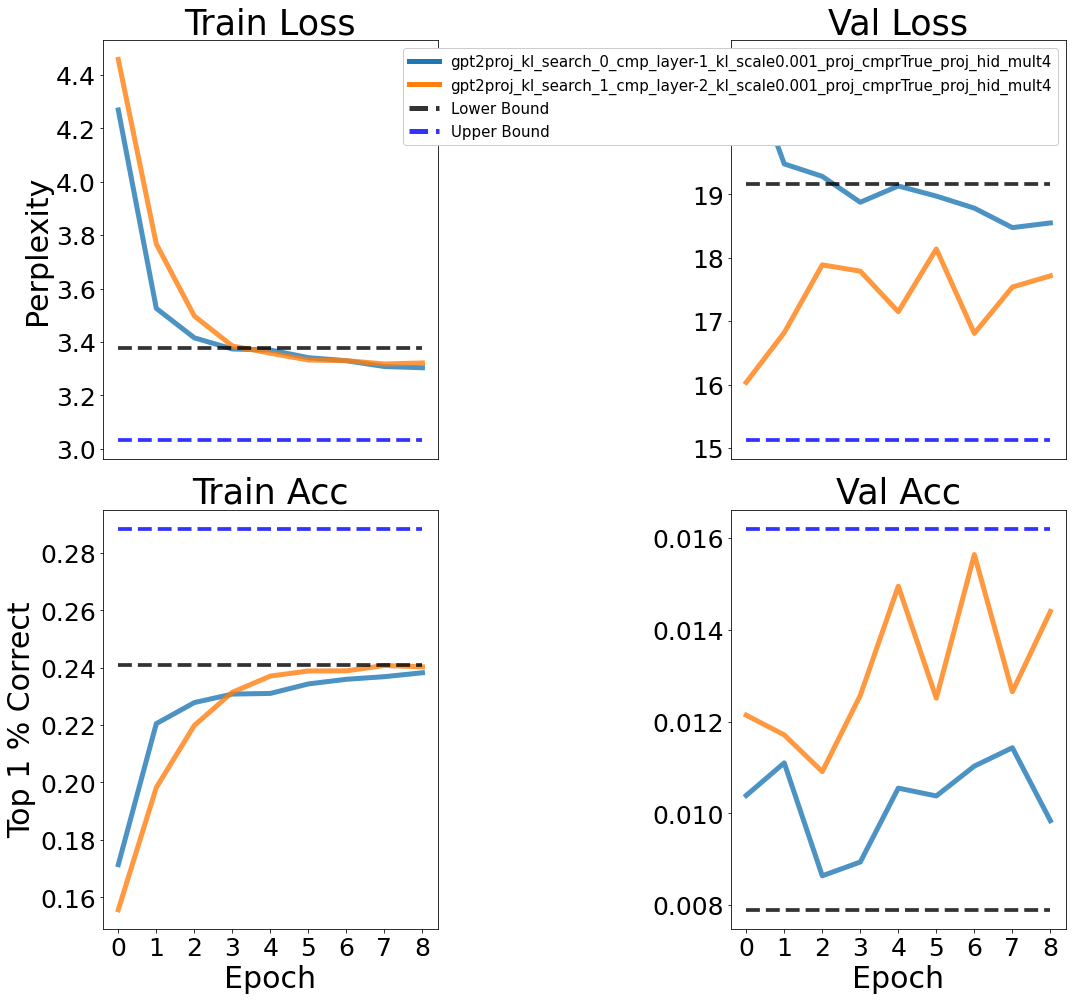

In [52]:
save_name = "fwd_loss_acc.pdf"
legendsize = 15
fontsize = 25
titlesize = 35
labelsize = 30
thickness = 5
legthickness = 5
alpha = 0.8
plot_hue = "plot_name"
manual_ticks = False
n_epochs = np.max(df["epoch"]) + 1
figsize = (15,14)
fig, axes = plt.subplots(2,2,figsize=figsize)

plot_df = prep_df
palette = color_map if np.all([x in color_map for x in set(plot_df[plot_hue])]) else None

ax = axes[0][0]
plt.sca(ax)
sns.lineplot(x="epoch", y="train_perp", hue=plot_hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha, palette=palette)
ax.plot(np.arange(0,n_epochs), [base["tlow_perp"][0] for i in range(n_epochs)], "--k",  label="Lower Bound",  alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["thigh_perp"][0] for i in range(n_epochs)], "--b", label="Upper Bound",alpha=alpha, linewidth=3*thickness/4)
plt.title("Train Loss", fontsize=titlesize)
plt.xlabel("", fontsize=labelsize)
plt.ylabel("Perplexity", fontsize=labelsize)
plt.xticks([], fontsize=fontsize)
if manual_ticks:
    yticks = [2.7, 3.0, 3.3]
    ylabels = yticks
    plt.yticks(yticks, ylabels, fontsize=fontsize)
    plt.ylim([2.65, 3.4])
else:
    plt.yticks(fontsize=fontsize)
plt.legend().set_visible(False)

ax = axes[0][1]
plt.sca(ax)
sns.lineplot(x="epoch", y="val_perp", hue=plot_hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha, palette=palette)
ax.plot(np.arange(0,n_epochs), [base["low_perp"][0] for i in range(n_epochs)], "--k",  label="Lower Bound",alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["high_perp"][0] for i in range(n_epochs)], "--b", label="Upper Bound",alpha=alpha, linewidth=3*thickness/4)
plt.title("Val Loss", fontsize=titlesize)
plt.xlabel("", fontsize=labelsize)
plt.ylabel("")
plt.xticks([], fontsize=fontsize)
if manual_ticks:
    yticks = [15,17,19]
    ylabels = yticks
    plt.yticks(yticks, ylabels, fontsize=fontsize)
else:
    plt.yticks(fontsize=fontsize)
leg = plt.legend(loc="upper right",fontsize=legendsize, framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(legthickness)

#plt.tight_layout()
#plt.savefig("fwd_loss.pdf", tight_layout=True)
#plt.show()

#fig, axes = plt.subplots(1,2,figsize=figsize)

plot_df = prep_df
palette = color_map if np.all([x in color_map for x in set(plot_df[plot_hue])]) else None

ax = axes[1][0]
plt.sca(ax)
sns.lineplot(x="epoch", y="train_acc", hue=plot_hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha, palette=palette)
ax.plot(np.arange(0,n_epochs), [base["tlow_acc"][0] for i in range(n_epochs)], "--k", label="Low",alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["thigh_acc"][0] for i in range(n_epochs)], "--b", label="High",alpha=alpha, linewidth=3*thickness/4)
plt.title("Train Acc", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("Top 1 % Correct", fontsize=labelsize)
if manual_ticks:
    xticks = [0,10,20,30]
    plt.xticks(xticks, fontsize=fontsize)
    yticks = [0.24, 0.28, 0.32]
    ylabels = [24, 28, 32]
    plt.yticks(yticks, ylabels, fontsize=fontsize)
else:
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
plt.legend().set_visible(False)

ax = axes[1][1]
plt.sca(ax)
sns.lineplot(x="epoch", y="val_acc", hue=plot_hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha, palette=palette)
ax.plot(np.arange(0,n_epochs), [base["low_acc"][0] for i in range(n_epochs)], "--k", label="Low",alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["high_acc"][0] for i in range(n_epochs)], "--b", label="High",alpha=alpha, linewidth=3*thickness/4)
plt.title("Val Acc", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("")
if manual_ticks:
    xticks = [0,10,20,30]
    plt.xticks(xticks, fontsize=fontsize)
    yticks = [0.008, 0.012, 0.016]
    ylabels = [0.8, 1.2, 1.6]
    plt.yticks(yticks, ylabels, fontsize=fontsize)
else:
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
plt.legend().set_visible(False)

plt.tight_layout()
plt.savefig(save_name, tight_layout=True)
plt.show()

ValueError: Could not interpret value `rmb_train_loss` for parameter `y`

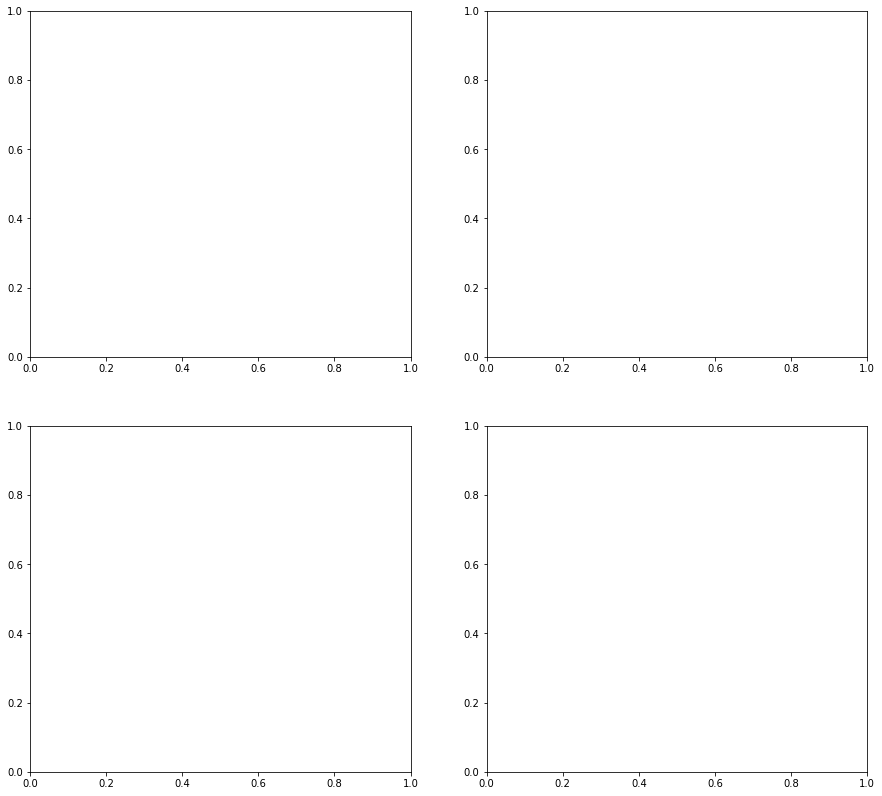

In [43]:
fig, axes = plt.subplots(2,2,figsize=figsize)

plot_df = prep_df

ax = axes[0][0]
plt.sca(ax)
sns.lineplot(x="epoch", y="rmb_train_loss", hue=hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha)
ax.plot(np.arange(0,n_epochs), [base["tlow_loss"][0] for i in range(n_epochs)], "--k", label="Low",alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["thigh_loss"][0] for i in range(n_epochs)], "--b", label="High",alpha=alpha, linewidth=3*thickness/4)
plt.title("RMB Train Loss", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("Loss", fontsize=labelsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

ax = axes[0][1]
plt.sca(ax)
sns.lineplot(x="epoch", y="rmb_val_loss", hue=hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha)
ax.plot(np.arange(0,n_epochs), [base["low_loss"][0] for i in range(n_epochs)], "--k", label="Low",alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["high_loss"][0] for i in range(n_epochs)], "--b", label="High",alpha=alpha, linewidth=3*thickness/4)
plt.title("RMB Val Loss", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

ax = axes[1][0]
plt.sca(ax)
sns.lineplot(x="epoch", y="rmb_train_acc", hue=hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha)
ax.plot(np.arange(0,n_epochs), [base["tlow_acc"][0] for i in range(n_epochs)], "--k", label="Low",alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["thigh_acc"][0] for i in range(n_epochs)], "--b", label="High",alpha=alpha, linewidth=3*thickness/4)
plt.title("RMB Train Acc", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("% Correct, Top 1", fontsize=labelsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

ax = axes[1][1]
plt.sca(ax)
sns.lineplot(x="epoch", y="rmb_val_acc", hue=hue, data=plot_df, ax=ax, linewidth=thickness, alpha=alpha)
ax.plot(np.arange(0,n_epochs), [base["low_acc"][0] for i in range(n_epochs)], "--k", label="Low",alpha=alpha, linewidth=3*thickness/4)
ax.plot(np.arange(0,n_epochs), [base["high_acc"][0] for i in range(n_epochs)], "--b", label="High",alpha=alpha, linewidth=3*thickness/4)
plt.title("RMB Val Acc", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2,figsize=figsize)

plot_df = prep_df

ax = axes[0]
plt.sca(ax)
sns.lineplot(x="epoch", y="csl_train_loss", hue=hue, data=plot_df, ax=ax)
plt.title("CSL Train Loss", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("Loss", fontsize=labelsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

ax = axes[1]
plt.sca(ax)
sns.lineplot(x="epoch", y="csl_val_loss", hue=hue, data=plot_df, ax=ax, )
plt.title("CSL Val Loss", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("Loss", fontsize=labelsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1,2,figsize=figsize)

plot_df = prep_df

ax = axes[0]
plt.sca(ax)
sns.lineplot(x="epoch", y="csl_train_acc", hue=hue, data=plot_df, ax=ax)
plt.title("CSL Train Acc", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("% Correct, Top 1", fontsize=labelsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

ax = axes[1]
plt.sca(ax)
sns.lineplot(x="epoch", y="csl_val_acc", hue=hue, data=plot_df, ax=ax, )
plt.title("CSL Val Acc", fontsize=titlesize)
plt.xlabel("Epoch", fontsize=labelsize)
plt.ylabel("% Correct, Top 1", fontsize=labelsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.tight_layout()
plt.show()